# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpp4y1kk4t
  JVM stdout: /tmp/tmpp4y1kk4t/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpp4y1kk4t/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_patrickh_5h0wy6
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


# Random Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000)
random = ds_.make_random()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in random.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
random[y] = random[y].asfactor()
rtrain, rvalid, _ = random.split_frame([0.4, 0.3], seed = 12345)
print(rtrain.shape)
print(rvalid.shape)

(80049, 17)
(59947, 17)


In [8]:
rtrain_pd = rtrain.as_data_frame()
rvalid_pd = rvalid.as_data_frame()

In [9]:
rtrain_dm = xgb.DMatrix(rtrain_pd[X],
                        rtrain_pd[y])
rvalid_dm = xgb.DMatrix(rvalid_pd[X],
                        rvalid_pd[y])

In [10]:
ave_y = rtrain_pd['target'].mean()
print(ave_y)

0.5012554810178765


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.5,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 18,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.01,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rtrain_dm, 'train'), (rvalid_dm, 'eval')]

random_model = xgb.train(params, 
                         rtrain_dm, 
                         400,
                         evals=watchlist,
                         early_stopping_rounds=50,
                         verbose_eval=True)

[0]	train-auc:0.535466	eval-auc:0.499067
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.54452	eval-auc:0.497296
[2]	train-auc:0.553027	eval-auc:0.497761
[3]	train-auc:0.561051	eval-auc:0.500392
[4]	train-auc:0.569786	eval-auc:0.501116
[5]	train-auc:0.571478	eval-auc:0.50034
[6]	train-auc:0.576353	eval-auc:0.499641
[7]	train-auc:0.580708	eval-auc:0.500343
[8]	train-auc:0.588571	eval-auc:0.500076
[9]	train-auc:0.590005	eval-auc:0.50083
[10]	train-auc:0.592444	eval-auc:0.501285
[11]	train-auc:0.596731	eval-auc:0.501683
[12]	train-auc:0.602872	eval-auc:0.500873
[13]	train-auc:0.605908	eval-auc:0.500947
[14]	train-auc:0.611227	eval-auc:0.500946
[15]	train-auc:0.616366	eval-auc:0.50127
[16]	train-auc:0.621186	eval-auc:0.501354
[17]	train-auc:0.622577	eval-auc:0.501509
[18]	train-auc:0.625427	eval-auc:0.501788
[19]	train-auc:0.627586	eval-auc:0.501774
[20]	train-auc:0.630901	eval-auc:

# Global Variable Importance 

***

#### XGBoost variable importance

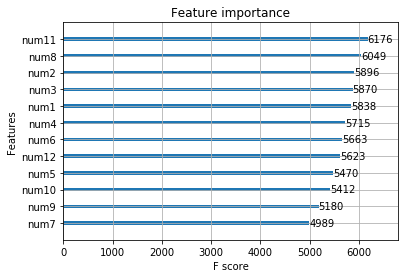

In [12]:
_ = plot_importance(random_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(random_model)

Weight,Feature
0.0847,num9
0.0843,num11
0.0843,num4
0.0841,num7
0.0836,num10
0.0835,num5
0.0831,num6
0.0830,num2
0.0830,num3
0.0830,num12


#### Shapley variable importance

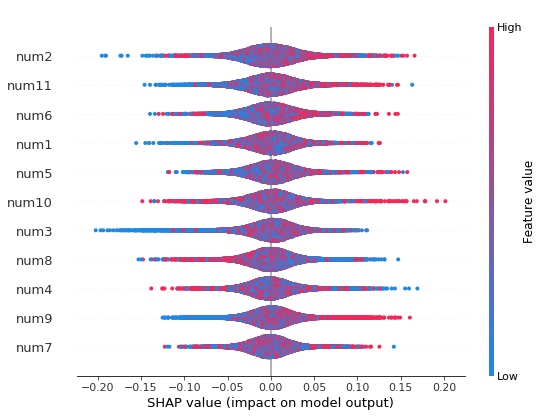

In [14]:
shap_values = random_model.predict(rvalid_dm, pred_contribs=True)
shap.summary_plot(shap_values[:, :-1], rvalid_pd[random_model.feature_names])

# Model Visualizations: Decision Tree Surrogates, Partial Dependence, and Individual Conditional Expectation

***

#### Function for calculating partial dependence

In [15]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [16]:
par_dep_num11 = par_dep('num11', rvalid_pd[X], random_model)

In [17]:
par_dep_num11

,num11,partial_dependence
0,-4.191434,0.497065
1,-3.773000,0.497065
2,-3.354565,0.497065
3,-2.936131,0.490722
4,-2.517697,0.500287
5,-2.099263,0.505075
6,-1.680829,0.496347
7,-1.262394,0.499603
8,-0.843960,0.500020
9,-0.425526,0.501286


#### Bind XGBoost predictions to training data

In [18]:
random_preds = pd.DataFrame(random_model.predict(rvalid_dm))

In [19]:
random_decile_frame = pd.concat([rvalid_pd, random_preds], axis=1)
random_decile_frame = random_decile_frame.rename(columns={0: 'predict'})
random_decile_hframe = h2o.H2OFrame(random_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [20]:
random_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,0.471918
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,0.500790
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,0.474551
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,0.495823
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,0,10,0.460597


#### Find percentiles of XGBoost predictions

In [21]:
random_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', random_decile_hframe)

In [22]:
random_percentile_dict

{0: 34868,
 10: 58156,
 20: 7722,
 30: 2084,
 40: 91463,
 50: 169947,
 60: 133437,
 70: 43365,
 80: 147440,
 90: 72286,
 99: 68395}

#### Calculate ICE curve values

In [23]:
# retreive bins from original partial dependence calculation
bins_num11 = list(par_dep_num11['num11'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(random_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_num11[col_name] = par_dep('num11', 
                                      rvalid_pd[rvalid_pd['row_id'] == int(random_percentile_dict[i])][X], 
                                      random_model, 
                                      bins=bins_num11)['partial_dependence']


#### Display partial dependence and ICE for num11

In [24]:
par_dep_num11

,num11,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-4.191434,0.497065,0.412613,0.440801,0.502786,0.471572,0.555712,0.468601,0.479622,0.496368,0.490589,0.527737,0.585383
1,-3.773000,0.497065,0.412613,0.440801,0.502786,0.471572,0.555712,0.468601,0.479622,0.496368,0.490589,0.527737,0.585383
2,-3.354565,0.497065,0.412613,0.440801,0.502786,0.471572,0.555712,0.468601,0.479622,0.496368,0.490589,0.527737,0.585383
3,-2.936131,0.490722,0.400389,0.439449,0.490483,0.464938,0.552573,0.457010,0.476528,0.492364,0.476693,0.530358,0.585734
4,-2.517697,0.500287,0.404889,0.451077,0.494124,0.470515,0.549167,0.472026,0.503350,0.500405,0.492162,0.532872,0.594379
5,-2.099263,0.505075,0.387253,0.482532,0.505784,0.521218,0.532609,0.472173,0.496505,0.508297,0.481881,0.540874,0.600014
6,-1.680829,0.496347,0.375589,0.458343,0.457410,0.504329,0.514063,0.464377,0.514745,0.524384,0.482923,0.488593,0.606940
7,-1.262394,0.499603,0.379370,0.466436,0.486114,0.503335,0.496818,0.463441,0.503651,0.516121,0.496259,0.499457,0.609534
8,-0.843960,0.500020,0.386112,0.461623,0.463937,0.483986,0.491039,0.461306,0.513947,0.535206,0.505440,0.522365,0.587977
9,-0.425526,0.501286,0.382255,0.444331,0.483635,0.484856,0.487671,0.508651,0.507219,0.526896,0.500575,0.519165,0.564486


#### Plot partial dependence and ICE

In [25]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


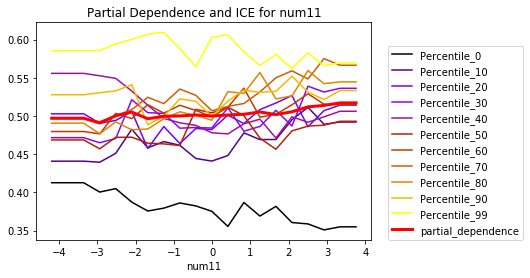

In [26]:
plot_par_dep_ICE('num11', par_dep_num11)

#### Train single h2o decision tree

In [27]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=random_decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip


#### Create GraphViz dot file

In [28]:
# title for plot
title = 'Random Data Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Random Data Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [29]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


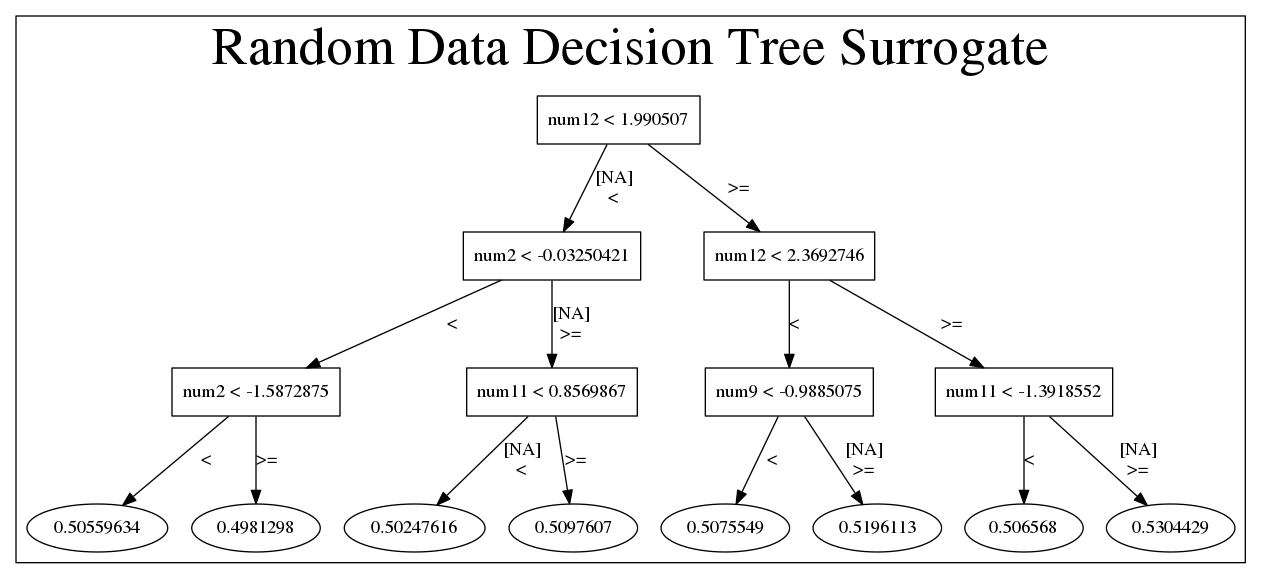

In [30]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the TreeInterpreter results at the chosen decile 

In [31]:
def eli5_dd(decile):
    row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(random_model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(random_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [32]:
# explainer = LIMEExplainer(training_frame=rvalid_pd, X=X, model=random_model, discretize=None)
explainer = LIMEExplainer(training_frame=rvalid_pd, X=X, model=random_model)
def lime(decile):
    row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displayes the Shapley results at the chosen decile

In [33]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [34]:
decile = 10
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num3                         -0.134873
num12                        -0.017771
num4                         -0.015488
num6                         -0.010684
num8                         -0.010456
num11                        -0.008395
num9                         -0.004636
num10                        -0.001315
num2                          0.000440
num1                          0.005614
num7                          0.015273
num5                          0.020694 

Shapley sum:  -0.15409629
Model prediction:  -0.15409658730549192


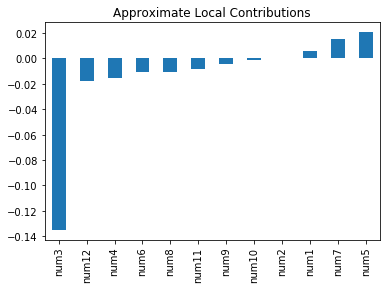

In [35]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7f2f075f54a8>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num7', weight=0.050899622258450905, std=None, value=-1.1797258150395715), FeatureWeight(feature='num8', weight=0.02058268283130926, std=None, value=-0.6795578116169879), FeatureWeight(feature='num6', weight=0.019275605420314833, std=None, value=0.5222305873943809), FeatureWeight(feature='<BIAS>', weight=0.0024785083961645195, std=None, value=1.0)], neg=[FeatureWeight(feature='num3', weight=-0.092512559921946, std=None, value=-2.408120161173479), FeatureWeight(feature='num2', weight=-0.0498738421372903, std=None, value=0.05261027051625167), FeatureWeight(feature='num12', weight=-0.03416432789173531, std=None, value=0.4528102538058728), FeatureWeight(feature='num10', weight=-0.02728284739285265, std=None, value=0.17150856069685005), FeatureWeight(feature='num11', weight=-0.022049702220734248, std=None, value=-1.0805628225837591), FeatureWeight(feature='num5', weight=-0.01688615747202756, std=None, value=-0.5578278152807942), FeatureWeight(feature='num4', weight=-0.005058055725168491, std=None, value=0.603793812726167), FeatureWeight(feature='num9', weight=-0.0028230340803961675, std=None, value=-0.7148571300156646), FeatureWeight(feature='num1', weight=-0.0017044368640887517, std=None, value=-0.34854014788656595)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.1591185447999999, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

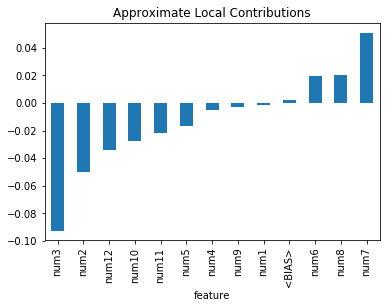

In [36]:
eli5_dd(decile)

In [37]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -0.15409658730549192


### LIME


Model Prediction: 0.46
Local GLM Prediction: 0.48
Local GLM R-square: 0.30
Local GLM Intercept: 0.49

Approximate Local Contributions:
   Input  Local Contribution
0   num1       -5.954458e-03
1   num3       -1.065449e-03
2   num5       -1.564458e-10
3   num7       -1.267172e-13
4   num8       -1.434628e-15
5   num9       -2.432777e-17
6  num11       -7.412715e-18
7   num6        2.858882e-12
8   num4        2.640229e-05
9   num2        1.983537e-04
None


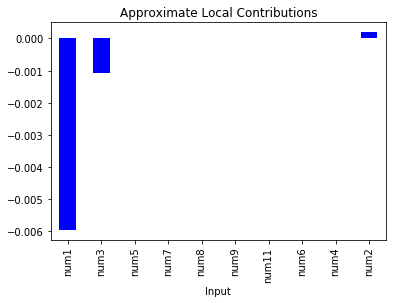

In [38]:
lime(decile)

##  Median of predictions

In [39]:
decile = 50
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num3                         -0.030386
num7                         -0.028035
num5                         -0.024358
num12                        -0.006305
num6                         -0.005451
num10                        -0.004068
num1                         -0.002989
num11                         0.003265
num9                          0.011436
num8                          0.016307
num4                          0.022326
num2                          0.048216 

Shapley sum:  0.007458045
Model prediction:  0.0074577677198011325


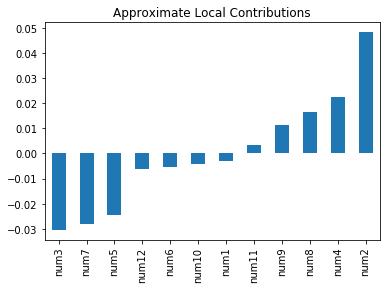

In [40]:
shapley(row)

### TreeInterpreter 

Explanation(estimator='<xgboost.core.Booster object at 0x7f2f075f54a8>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num2', weight=0.05835000960047233, std=None, value=0.4233995602916179), FeatureWeight(feature='num1', weight=0.026377858565419722, std=None, value=-0.0572218000852981), FeatureWeight(feature='num11', weight=0.018827452924453057, std=None, value=-0.21189549873403532), FeatureWeight(feature='num8', weight=0.016272807949626347, std=None, value=-0.18377404925779134), FeatureWeight(feature='num4', weight=0.01367424512147109, std=None, value=-1.6882615980896034), FeatureWeight(feature='<BIAS>', weight=0.0024785083961645195, std=None, value=1.0)], neg=[FeatureWeight(feature='num10', weight=-0.038985741790714463, std=None, value=0.6345262933645954), FeatureWeight(feature='num6', weight=-0.028927384218766495, std=None, value=-1.2858388088290729), FeatureWeight(feature='num3', weight=-0.023261267712252388, std=None, value=-1.362222694602903), FeatureWeight(feature='num12', weight=-0.022379034415580527, std=None, value=0.21217583266303372), FeatureWeight(feature='num5', weight=-0.015830335838675318, std=None, value=-0.062365634985276086), FeatureWeight(feature='num9', weight=-0.0029379334641839467, std=None, value=1.3646758936023018), FeatureWeight(feature='num7', weight=-0.001223042517433898, std=None, value=0.769501396233219)], pos_remaining=0, neg_remaining=0), proba=None, score=0.0024361426000000276, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

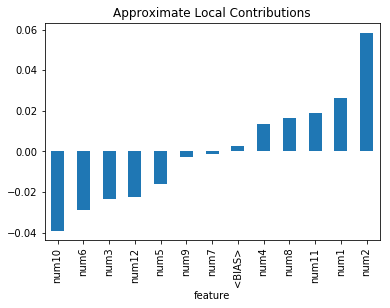

In [41]:
eli5_dd(decile)

In [42]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.0074577677198011325


### LIME


Model Prediction: 0.50
Local GLM Prediction: 0.51
Local GLM R-square: 0.07
Local GLM Intercept: 0.51

Approximate Local Contributions:
  Input  Local Contribution
0  num1       -4.746100e-04
1  num3       -2.957221e-05
2  num4       -8.671356e-10
3  num5       -2.737019e-13
4  num6       -4.796315e-14
5  num8       -2.214835e-18
6  num7        2.411252e-16
7  num2        2.508948e-04
None


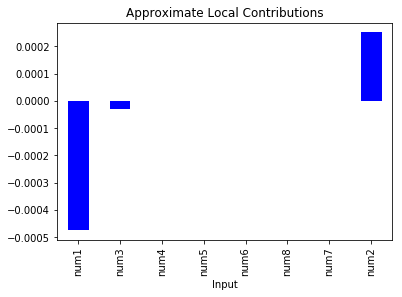

In [43]:
lime(decile)

##  90th decile of model predictions

In [44]:
decile = 90
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num7                         -0.029583
num5                         -0.011806
num12                        -0.005786
num1                         -0.004182
num4                          0.002340
num3                          0.002490
num9                          0.015018
num8                          0.018888
num6                          0.024857
num10                         0.034684
num11                         0.054179
num2                          0.062163 

Shapley sum:  0.1707626
Model prediction:  0.17076262764829642


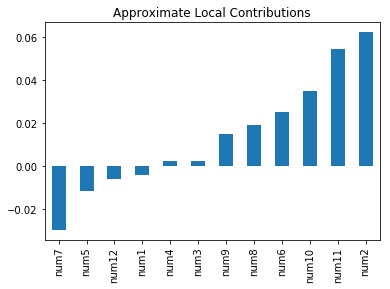

In [45]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7f2f075f54a8>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num2', weight=0.07012497664177501, std=None, value=-2.2635125743962607), FeatureWeight(feature='num11', weight=0.04636603702355229, std=None, value=1.4588554681712602), FeatureWeight(feature='num3', weight=0.045013551479984794, std=None, value=-0.14365734878464526), FeatureWeight(feature='num8', weight=0.024771073754352623, std=None, value=0.6972477232949149), FeatureWeight(feature='num1', weight=0.01523510519829769, std=None, value=0.7287514564329708), FeatureWeight(feature='num6', weight=0.009885511725427783, std=None, value=1.4689772450840466), FeatureWeight(feature='<BIAS>', weight=0.0024785083961645195, std=None, value=1.0), FeatureWeight(feature='num9', weight=0.0016108967600781017, std=None, value=-0.5765026543811111)], neg=[FeatureWeight(feature='num5', weight=-0.02001538064566756, std=None, value=-0.31036275219528003), FeatureWeight(feature='num10', weight=-0.0178367876705009, std=None, value=-0.6073118554490511), FeatureWeight(feature='num7', weight=-0.005727911968627793, std=None, value=0.3801433126562771), FeatureWeight(feature='num12', weight=-0.004600593022012988, std=None, value=-1.0965451693646988), FeatureWeight(feature='num4', weight=-0.0015643615728234447, std=None, value=0.1230252298552604)], pos_remaining=0, neg_remaining=0), proba=None, score=0.1657406261, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

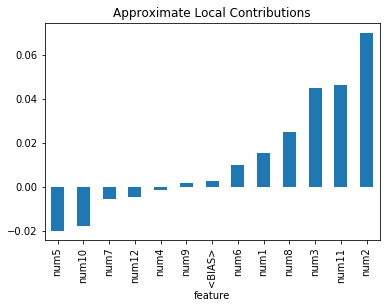

In [46]:
eli5_dd(decile)

In [47]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.17076262764829642


### LIME


Model Prediction: 0.54
Local GLM Prediction: 0.50
Local GLM R-square: 0.14
Local GLM Intercept: 0.50

Approximate Local Contributions:
   Input  Local Contribution
0   num2       -3.906393e-03
1   num3       -3.189072e-06
2   num5       -1.366264e-11
3  num11        1.006966e-17
4   num8        8.121994e-17
5   num7        3.056748e-15
6   num6        8.715801e-13
7   num4        3.996766e-10
8   num1        9.249592e-03
None


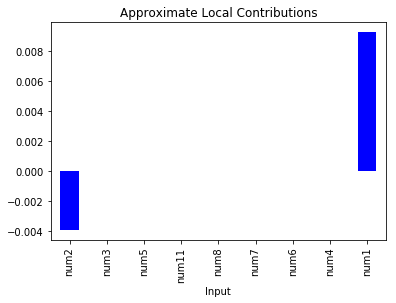

In [48]:
lime(decile)